Il programma riportato in questo Notebook, è realizzato per simulare il fenomeno del flocking, tipico di molti uccelli. Viene considerato come modello matematico il modello di Cucker-Smale ridefinito senza considerare la scatola.

Si fa riferimento all'articolo: [1] *Analysis and simulations of a refined flocking and swarming model of Cucker-Smale type,Kinetic & Related Models,4,1,1,16,2011-1-1,Martial Agueh,Reinhard Illner,Ashlin Richardson,1937-5093_2011_1_1, swarming, particle model, kinetic equation.,Flocking* 

In [2]:
import numpy as np
import random as rd
import math as mp
import scipy.integrate as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

Alcuni parametri di riferimento utilizzati in questo notebook sono stati presi dalla seguente tabella:

![Parametri](Img/TabellaParametri.jpg)

In [3]:
steps         =  5
birds         = 50
B1            =  0.5
H             =  0.1
ndim          =  3

#Variabili utili nel programma
C             =  0.003
D3            =  0.0015
E3            =  0.0003
D0            =  1
E0            =  1
P1            =  0.1
D1            =  5
E1            =  2.5
S1            =  1.047
S2            =  1.57
alpha         = 14.4
beta          =  0.1
init_vel_max  = 18
init_vel_min  = 10
init_radius   = 50

x_upper_bound = birds * ndim
v_lower_bound = x_upper_bound
v_upper_bound = 2 * birds * ndim

R_range       = 1.2
R_force       = H * 3

time_values = np.zeros((steps))
for i in range (steps):
    time_values[i] = i

init_phase_space = np.zeros((birds * 2 * ndim))

Funzioni utili a recuperare la posizione e la velocità di un uccello di una singola dimensione (x, y o z)

In [4]:
def get_pos(bird_set, i, k):
    return bird_set[i * ndim + k]

def get_vel(bird_set, i, k):
    return bird_set[v_lower_bound + i * ndim + k]

Funzioni che permettono di calcolare il modulo della differenze delle posizione e delle velocità di una coppia di uccelli

In [5]:
def pos_diff_norm(bird_set, i, j):
    somma = 0
    for k in range(ndim):
        somma += (get_pos(bird_set, i, k) - get_pos(bird_set, j, k)) ** 2
    somma = mp.sqrt(somma)
    return somma

def vel_diff_norm(bird_set, i, j):
    somma = 0
    for k in range(ndim):
        somma += (get_vel(bird_set, i, k) - get_vel(bird_set, j, k)) ** 2
    somma = mp.sqrt(somma)
    return somma

Calcolo dell'attrattività A seguendo la formula del Cucker-Smale classico:

![Formula.png](Img/classico1.jpg)
![Formula.png](Img/classico2.jpg)

In [6]:
def Aij(bird_set, i, j):
    return H / (pow(1 + pow(vel_diff_norm(bird_set, i, j), 2), B1))

In [7]:
def A(bird_set, i, j, k):
    v_jk = get_vel(bird_set, j, k)
    v_ik = get_vel(bird_set, i, k)
    return Aij(bird_set, i, j) * (v_jk - v_ik)

In [8]:
def R(bird_set, i, j, k):
    x_ik = get_pos(bird_set, i, k)
    x_jk = get_pos(bird_set, j, k)
    
    norm = pos_diff_norm(bird_set, i, j)
    cut = cutoff(norm, 0, R_range)
    
    if cut == 0:
        return 0
    else: 
        return R_force * cut * (x_ik - x_jk) / norm

Funzione rho utilizzata nel Cucker-Smale ridefinito per il calcolo di B:

![Rho.png](Img/rho.jpg)

In [9]:
def rho(bird_set, i):
    somma = 0
    for j in range(birds):
        somma += 1 / (1 + pos_diff_norm(bird_set, i, j) ** 2)
    return somma / birds

Funzione cutoff del Cucker-Smale ridefinito:

![Cutoff.png](Img/CutOff.jpg)

In [10]:
#Funzione cutoff per S0, S1, S2 e S3
def cutoff(x, d, e):
    if x <= d:
        return 1
    elif x < (d + e):
        return 0.5 + 0.5 * np.tanh((1 / (x - d)) + (1 / (x - (d + e))))
    else:
        return 0

Calcolo B come da articolo di riferimento:

![B.png](Img/B.jpg)

In [11]:
def B(bird_set, i, k):
    return C * cutoff(rho(bird_set, i), D3, E3) * cross_product(bird_set, i ,k)

Funzione per calcolare il prodotto vettoriale, componente per componente

In [12]:
def levi_civita(i, j, k):
    if ((i == 1 and j == 2 and k == 3) or
        (i == 2 and j == 3 and k == 1) or
        (i == 3 and j == 1 and k == 2)):
        return 1
    elif ((i == 3 and j == 2 and i == 1) or
         (i == 1 and j == 3 and k == 2) or
         (i == 2 and j == 1 and k == 3)):
        return -1
    else:
        return 0

In [13]:
def cross_product(bird_set, i, k):
    somma = 0
    down = [0, 0, -1]

    for i_k in range(ndim):
        for down_k in range(ndim):
            somma += levi_civita(k, i_k, down_k) * get_vel(bird_set, i, i_k) * down[down_k]
    return somma

Funzione per calcolare il coefficiente di attrito del Cucker-Smale ridefinito:

![Attrito.png](Img/attrito.jpg)

In [14]:
def friction(bird_set, i, k):
    v_ik = get_vel(bird_set, i, k)
    somma = 0
    
    for l in range (ndim):
        somma += get_vel(bird_set, i, l) ** 2
    v_norm = mp.sqrt(somma)
    return (alpha - beta * v_norm ** 2) * v_ik

Esegue la formula del Cucker-Smale ridefinito:

![Formula.png](Img/FormulaCucker.jpg)

La funzione calcola il Cucker-Smale ridefinito, ma utilizza un unico vettore unidimensionale contententi tutte le posizioni e tutte le velocità degli uccelli per ogni dimensione per favorire il funzionamento della funzione *Runge-Kutta*.

In [15]:
def rhs_equation(t, phase_space):
    vett = np.zeros(birds * 2 * ndim)    
    
    #equazioni differenziali delle posizioni
    for i in range (birds):
        x_i = i * ndim
        for k in range(ndim):
            vett[x_i + k] = get_vel(phase_space, i, k)
    
    #equazioni differenziali delle velocità
    for i in range (birds):
        v_i = v_lower_bound + ndim * i
        somma = np.zeros((ndim))
        
        for k in range (ndim):
            for j in range (birds):
                if j != i:
                    somma[k] += A(phase_space, i, j, k) + R(phase_space, i, j, k)
            somma[k] += B(phase_space, i, k) + friction(phase_space, i, k)
            vett[v_i + k] = somma[k]
            
    return vett

Inizializzazione delle velocità iniziali e delle posizioni iniziali con coordinate sferiche.

In [16]:
rd.seed()

#inizializzo le posizioni
for i in range (birds):
    x_i = ndim * i
    theta_x = rd.random() * mp.pi
    phi_x = rd.random() * 2 * mp.pi
    r = rd.random() * init_radius
    
    init_phase_space[x_i + 0]= r * mp.cos(phi_x) * mp.sin(theta_x)
    init_phase_space[x_i + 1]= r * mp.sin(phi_x) * mp.sin(theta_x)
    init_phase_space[x_i + 2]= r * mp.cos(theta_x)

#inizializzo le velocità
for i in range (birds):
    v_i = v_lower_bound + ndim * i
    theta_v = rd.random() * mp.pi
    phi_v = rd.random() * 2 * mp.pi
    v = rd.random() * (init_vel_max - init_vel_min) + init_vel_min
    
    init_phase_space[v_i + 0]= v * mp.cos(phi_v) * mp.sin(theta_v)
    init_phase_space[v_i + 1]= v * mp.sin(phi_v) * mp.sin(theta_v)
    init_phase_space[v_i + 2]= v * mp.cos(theta_v)

Chiamata al metodo *Runge-Kutta* di ordine 4 *RK45*.

Parametri:

fun    : Funzione per il calcolo *Cucker-Smale*;

y0     : Vettore unidimensionale con velocità e posizioni inizializzate;

t_span : Tempo minimo e massimo

In [17]:
solution = sp.solve_ivp(fun = rhs_equation, y0 = init_phase_space, t_span = (0, steps))

Salvataggio delle posizioni, velocità e tempo in un file di testo.

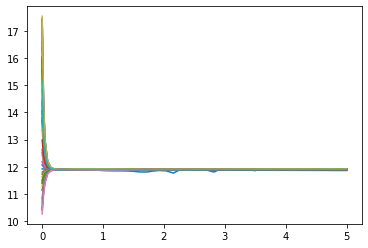

In [18]:
pos = solution.y[ :x_upper_bound]
vel = solution.y[v_lower_bound: ]
times = solution.t

#Converto in array 3D
vel = vel.reshape((birds, ndim, len(times)))
pos = pos.reshape((birds, ndim, len(times)))

vel = np.round(vel, 5)
pos = np.round(pos, 5)
times = np.round(times, 5)

file = open(f"ridefinito birds={birds} times={times.size} b={B1}.txt", "w+")
file.write("Num.\tVelx\tVely\tVelz\tPosx\tPosy\tPosz\tTimes\tStep\n")

ucc = 0
t = 0
for i in range(times.size * birds):
    file.write(str(ucc) + "\t" + str(vel[ucc][0][t]) + "\t" + str(vel[ucc][1][t]) + "\t" + str(vel[ucc][2][t]) + 
               "\t" + str(pos[ucc][0][t]) + "\t" + str(pos[ucc][1][t]) + "\t" + str(pos[ucc][2][t]) + 
               "\t" + str(times[t]) + "\t" + str(t) + "\n")
    ucc += 1
    if ucc == birds:
        ucc = 0
        t += 1     

file.close()

norm_vel = np.zeros((birds, len(times)))
for i in range(birds):
    for t in range(len(times)):
        norm_vel[i, t] = np.linalg.norm(vel[i, :, t])
   
for i in range(birds):
    plt.plot(times, norm_vel[i,:])

Per una più veloce esecuzione della simulazione, le velocità e le posizioni ad ogni instante di tempo vengono calcolate in un Cucker-Smale ridefinito senza scatola al fine anche di evitare i possibili effetti dei bordi. I risultati ottenuti verranno salvati in file di testo in modo tale da poter eseguire successivamente i calcoli e grafici.